### Environment Preparation

In [ ]:
# !apt-get update
# !apt install nvidia-cuda-toolkit -y

In [13]:
# !pip install swifter
# !pip uninstall -y tensorflow-gpu keras keras-transformer keras_bert
# !pip install tensorflow-gpu==1.14.0 keras==2.2.4 keras-transformer==0.33.0 keras_bert==0.78.0 
# !pip install tensorflow-gpu keras keras-transformer keras_bert tensorflow-ranking
# !pip install pydot pydotplus
# !pip install h5py==2.10.0 --force-reinstall

     |████████████████████████████████| 141 kB 5.0 MB/s            
  Using cached tensorflow_serving_api-2.7.0-py2.py3-none-any.whl (37 kB)
  Using cached tensorflow-2.7.0-cp37-cp37m-manylinux2010_x86_64.whl (489.6 MB)
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1


In [ ]:
# !apt-get install graphviz -y

### Download required embedding

In [ ]:
# !wget https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-12_H-768_A-12.zip data/
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip data/
# !wget https://nlp.stanford.edu/data/glove.840B.300d.zip data/

In [ ]:
# !unzip data/uncased_L-12_H-768_A-12.zip 
# !unzip data/crawl-300d-2M.vec.zip
# !unzip data/glove.840B.300d.zip 

### Run Preprocessing File

In [ ]:
# !python preprocess.py

### Imports


In [ ]:
# import tensorflow as tf
# tf.config.list_physical_devices("GPU")

In [14]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import gc
import json
import pandas as pd
import numpy as np
from random import choice, seed, shuffle, random, sample
import tensorflow as tf
# import tensorflow.co as KTF
from keras.models import Sequential, Model
from keras.layers import Input, CuDNNGRU as GRU, CuDNNLSTM as LSTM, Dropout, BatchNormalization
from keras.layers import Dense, Concatenate, Activation, Embedding, SpatialDropout1D, Bidirectional, Lambda, Conv1D
from keras.layers import Add, Average, TimeDistributed, GlobalMaxPooling1D
from tensorflow.compat.v1.keras.optimizers import Adam, Nadam
# from keras.activations import absolute_import
# from keras.legacy import interfaces
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import Callback
# from keras.utils import to_categorical
import tensorflow.compat.v1.keras.backend as K
# from keras.callbacks import ModelCheckpoint
import keras
# from sklearn.model_selection import KFold
# from keras.initializers import he_normal
# from keras_bert.bert import get_model
from keras_bert.loader import load_trained_model_from_checkpoint
from keras_bert import AdamWarmup, calc_train_steps
# from keras.engine import Layer
# from keras.engine import InputSpec
# from keras.objectives import categorical_crossentropy
# from keras.objectives import sparse_categorical_crossentropy
from keras import activations, initializers, regularizers, constraints
from keras.models import Model
# from tqdm import tqdm
# from model_utils import seq_gather, seq_and_vec, seq_maxpool
from keras.models import load_model
from keras_bert import get_custom_objects
from keras_bert import Tokenizer
from collections import defaultdict
from eval import read_submission, get_ndcg
from tqdm import tqdm, trange
import pickle
import dask.dataframe as dd
# import joblib

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True #不全部占满显存, 按需分配
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)
# gpus = tf.config.list_physical_devices('GPU')
# print(gpus)
# mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

BERT_PRETRAINED_DIR = "/root/Applied_AI_Lab_WiSe2021_Passau/ai-light/data/uncased_L-12_H-768_A-12"
VAL_ANS_PATH = '/root/Applied_AI_Lab_WiSe2021_Passau/ai-light/data/valid_answer.json'
LABEL_PATH = '/root/Applied_AI_Lab_WiSe2021_Passau/ai-light/data/multimodal_labels.txt'

MAX_EPOCH = 20
MAX_LEN = 10
B_SIZE = 64
FOLD_IDS = [-1]
FOLD_NUM = 20
THRE = 0.5
SHUFFLE = True
MAX_BOX = 5
MAX_CHAR = 5
PREFIX = "[image-bert-concat-query]-wwm_uncased_L12-768_v3_quart"
SEED = 2021
ACCUM_STEP = int(128 // B_SIZE)
SAVE_EPOCHS=[10, 20, 35, 50, 80, 100]
IMAGE_LABEM_CONCAT_TOKEN = "###"
CONCAT_TOKE = "[unused0]"

cfg = {}
cfg["verbose"] = PREFIX
cfg["base_dir"] = BERT_PRETRAINED_DIR
cfg['maxlen'] = MAX_LEN
cfg["max_box"] = MAX_BOX
cfg["max_char"] = MAX_CHAR
cfg["lr"] = 1e-4
cfg['min_lr'] = 6e-8
cfg["opt"] = "nadam"
cfg["loss_w"] =  20.
cfg["trainable"] = True
cfg["bert_trainable"] = True
cfg["mix_mode"] = ""   # add concat average
cfg["unit1_1"] = 128
cfg["accum_step"] = ACCUM_STEP
cfg["cls_num"] = 2
cfg["raw_filename"] = "{}_{}oof{}"


2021-12-19 15:30:43.399738: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9435 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:86:00.0, compute capability: 3.7
2021-12-19 15:30:43.400703: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9299 MB memory:  -> device: 1, name: Tesla K80, pci bus id: 0000:87:00.0, compute capability: 3.7


In [15]:
def get_vocab():
    if "albert"in cfg["verbose"].lower():
        dict_path = os.path.join(BERT_PRETRAINED_DIR, 'vocab_chinese.txt')
    else:
        dict_path = os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt')
    with open(dict_path, mode="r", encoding="utf8") as f:
        lines = f.readlines()
        lines = [l.strip() for l in lines]

    word_index = {v: k  for k, v in enumerate(lines)}
    return word_index


word_index = get_vocab()
cfg["x_pad"] = word_index["[PAD]"]
tokenizer = Tokenizer(word_index)


def get_label(path):
    with open(path) as f:
        lines = f.readlines()
        label2id = {l.split('\n')[0].split('\t')[1]:int(l.split('\n')[0].split('\t')[0]) for l in lines[1:]}
        id2label = {int(l.split('\n')[0].split('\t')[0]):l.split('\n')[0].split('\t')[1] for l in lines[1:]}
    return label2id, id2label


label2id, id2label = get_label(LABEL_PATH)
label_set = set(label2id.keys())

In [16]:
# 全量数据
# with open('../data/train_data.pkl', 'rb') as outp:
#     train_data= joblib.load(outp)
# 1w条
# with open('data/sample_train_data.pkl', 'rb') as outp:
#     train_data = joblib.load(outp)


with open('data/val_data.pkl', 'rb') as outp:
    val_data = pickle.load(outp)
    
# print(len(train_data), type(train_data))
# train_data.reset_index(drop=True, inplace=True)
# train_data.sample(3)

In [17]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype=np.float16)


def load_embed(path, dim=300, word_index=None):
    embedding_index = {}
    with open(path, mode="r", encoding="utf8") as f:
        lines = f.readlines()
        for l in lines:
            l = l.strip().split()
            word, arr = l[0], l[1:]
            if len(arr) != dim:
                print("[!] l = {}".format(l))
                continue
            if word_index and word not in word_index:
                continue
            word, arr = get_coefs(word, arr)
            embedding_index[word] = arr
    return embedding_index


def build_matrix(path, word_index=None, max_features=None, dim=300):
    embedding_index = load_embed(path, dim=dim, word_index=word_index)
    max_features = len(word_index) + 1 if max_features is None else max_features 
    embedding_matrix = np.zeros((max_features + 1, dim))
    unknown_words = []
    
    for word, i in word_index.items():
        if i <= max_features:
            try:
                embedding_matrix[i] = embedding_index[word]
            except KeyError:
                unknown_words.append(word)
    return embedding_matrix, unknown_words


def load_word_embed(word_embed_glove="data/glove.840B.300d.txt", 
                    word_embed_crawl="data/crawl-300d-2M.vec",
               save_filename="word_embedding_matrix",
               word_index=None):
    """
    (30524, 300) 7590
    (30524, 300) 7218
    """    
    if os.path.exists(save_filename + ".npy"):
        word_embedding_matrix = np.load(save_filename + ".npy").astype("float32")
    else:
        word_embedding_matrix, tx_unk = build_matrix(word_embed_glove, word_index=word_index, dim=300)

        # print(word_embedding_matrix.shape, len(tx_unk))
        
        word_embedding_matrix_v2, tx_unk = build_matrix(word_embed_crawl, word_index=word_index, dim=300)

        # print(word_embedding_matrix_v2.shape, len(tx_unk))
        
        word_embedding_matrix = np.concatenate([word_embedding_matrix, word_embedding_matrix_v2], axis=1)
        
        gc.collect()
        np.save(save_filename, word_embedding_matrix)
    return word_embedding_matrix


word_embedding_matrix = load_word_embed(word_index=word_index)

In [22]:
def build_model(cfg, summary=False, word_embedding_matrix=None):
    
    def _get_model(base_dir, cfg_=None):
        config_file = os.path.join(base_dir, 'bert_config.json')
        checkpoint_file = os.path.join(base_dir, 'bert_model.ckpt')
        if not os.path.exists(config_file):
            config_file = os.path.join(base_dir, 'bert_config_large.json')
            checkpoint_file = os.path.join(base_dir, 'roberta_l24_large_model')
        print(config_file, checkpoint_file)
#         model = load_trained_model_from_checkpoint(config_file, checkpoint_file, training=True, seq_len=cfg_['maxlen'])
        model = load_trained_model_from_checkpoint(config_file, 
                                           checkpoint_file, 
                                           training=False, 
                                           trainable=cfg_["bert_trainable"], 
                                           output_layer_num=cfg["cls_num"],
                                           seq_len=None)
        return model
    
    def get_opt(num_example, warmup_proportion=0.1, lr=2e-5, min_lr=None):
        if cfg["opt"].lower() == "nadam":
            opt = Nadam(lr=lr)
        else:
            total_steps, warmup_steps = calc_train_steps(
                num_example=num_example,
                batch_size=B_SIZE,
                epochs=MAX_EPOCH,
                warmup_proportion=warmup_proportion,
            )

            opt = AdamWarmup(total_steps, warmup_steps, lr=lr, min_lr=min_lr)

        return opt

    model1 = _get_model(cfg["base_dir"], cfg)
    model1 = Model(inputs=model1.inputs[: 2], outputs=model1.layers[-7].output)

    if word_embedding_matrix is not None:
        embed_layer = Embedding(input_dim=word_embedding_matrix.shape[0], 
                                output_dim=word_embedding_matrix.shape[1],
                                weights=[word_embedding_matrix],
                                trainable=cfg["trainable"],
                                name="embed_layer"
                         )
        
    inp_token1 = Input(shape=(None, ), dtype=np.int32, name="query_token_input")
    inp_segm1 = Input(shape=(None, ), dtype=np.float32, name="query_segm_input")
    
#     inp_token2 = Input(shape=(None, ), dtype=np.int32)
#     inp_segm2 = Input(shape=(None, ), dtype=np.float32)    
    
    inp_image = Input(shape=(None, 2048), dtype=np.float32, name="image_input")
    inp_image_mask = Input(shape=(None, ), dtype=np.float32, name="image_mask_input")
    inp_pos = Input(shape=(None, 5), dtype=np.float32, name="image_pos_input")        
    inp_image_char = Input(shape=(None, cfg["max_char"]), dtype=np.int32, name='image_char_input')
    
    
    mask = Lambda(lambda x: K.cast(K.not_equal(x, cfg["x_pad"]), 'float32'), name="token_mask")(inp_token1)
    word_embed = embed_layer(inp_token1)
    word_embed = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([word_embed, mask])
    word_embed = Bidirectional(LSTM(cfg["unit1_1"], return_sequences=True), merge_mode="sum")(word_embed)
    word_embed = Dropout(0.3)(word_embed)
    word_embed = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([word_embed, mask])

    sequence_output = model1([inp_token1, inp_segm1])
    sequence_output = Concatenate(axis=-1)([sequence_output, word_embed])
    text_pool = Lambda(lambda x: x[:, 0, :])(sequence_output)

    # Share weights of character-level embedding for premise and hypothesis
    character_embedding_layer = TimeDistributed(Sequential([
        embed_layer,
        # Embedding(input_dim=100, output_dim=char_embedding_size, input_length=chars_per_word),
        Conv1D(filters=128, kernel_size=3, name="char_embed_conv1d"),
        GlobalMaxPooling1D()
    ]), name='CharEmbedding')
    character_embedding_layer.build(input_shape=(None, None, cfg["max_char"]))
    image_char_embed  = character_embedding_layer(inp_image_char)    
    image_embed = Concatenate(axis=-1)([image_char_embed, inp_image])    
    image_embed = Dense(256, activation='relu', name='image_embed')(image_embed)
    image_embed = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([image_embed, inp_image_mask])
    pos_embed = Dense(256, activation='relu', name='pos_embed')(inp_pos)
    pos_embed = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([pos_embed, inp_image_mask])
    embed = Add()([image_embed , pos_embed]) # batch, maxlen(10), 1024+128
    
    image_embed = Bidirectional(LSTM(512, return_sequences=True), merge_mode="sum")(embed)
    image_embed = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([image_embed, inp_image_mask])
    
    image_pool = Lambda(lambda x: x[:, 0, :])(image_embed)
    
    pool = Concatenate(axis=-1)([image_pool, text_pool])
    pool = Dense(1024, activation="relu")(pool)
    pool = Dense(512, activation="relu")(pool)
    pool = Dense(128, activation="relu")(pool)
    
    output = Dense(2, activation='softmax', name='output')(pool)

    opt = get_opt(num_example=cfg["num_example"], lr=cfg['lr'], min_lr=cfg['min_lr'])
    model = Model(inputs=[inp_token1, inp_segm1, 
                          inp_image, inp_image_mask,
                          inp_pos, inp_image_char], outputs=[output])#
    
    model.compile(optimizer=opt, loss={
                'output': 'sparse_categorical_crossentropy'
            }, metrics=['accuracy'])
    if summary:
        model.summary()
    
    return model

# cfg["num_example"] = 32
# model = build_model(cfg, summary=True, word_embedding_matrix=word_embedding_matrix)

In [23]:
import csv
import base64


def convertBoxes(num_boxes, boxes):
    return np.frombuffer(base64.b64decode(boxes), dtype=np.float32).reshape(num_boxes, 4)
def convertFeature(num_boxes, features,):
    return np.frombuffer(base64.b64decode(features), dtype=np.float32).reshape(num_boxes, 2048)
def convertLabel(num_boxes, label):
    return np.frombuffer(base64.b64decode(label), dtype=np.int64).reshape(num_boxes)
def convertLabelWord(num_boxes, label):
    temp = np.frombuffer(base64.b64decode(label), dtype=np.int64).reshape(num_boxes)
    return '###'.join([id2label[t] for t in temp])
def convertPos(num_boxes, boxes, H, W):
    pos_list = []
    for i in range(num_boxes):
        temp = boxes[i]
        pos_list.append([temp[0]/W, 
                         temp[2]/W, 
                         temp[1]/H, 
                         temp[3]/H, 
                         ((temp[2] - temp[0]) * (temp[3] - temp[1]))/ (W*H),])
    return pos_list


def load_sample_data(path, frac=0.000001):
    ### Data Sampling and decoding
    train_data = dd.read_csv(path, sep='\t', blocksize=25e6, quoting=csv.QUOTE_NONE, error_bad_lines=False)
    
    sample_train_data = train_data.sample(frac=frac).compute()
    sample_train_data['words'] = sample_train_data['query']
    sample_train_data['label_words'] = sample_train_data.apply(lambda x: convertLabelWord(x['num_boxes'], x['class_labels']), axis=1,meta= pd.Series([], dtype=str, name='label_words'))
    sample_train_data['boxes_convert'] = sample_train_data.apply(lambda x: convertBoxes(x['num_boxes'], x['boxes']), axis=1, meta =pd.Series([], dtype=object, name='boxes_convert'))
    sample_train_data['features'] = sample_train_data.apply(lambda x: convertFeature(x['num_boxes'], x['features']), axis=1, meta=pd.Series([], dtype=object, name='features'))
    sample_train_data['pos'] = sample_train_data.apply(lambda x: convertPos(x['num_boxes'], x['boxes_convert'], x['image_h'], x['image_w']), axis=1, meta=pd.Series([], dtype=object, name='pos'))
    return sample_train_data[['words', 'label_words', 'boxes_convert', 'features', 'pos']].compute()


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.

    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            print(len(tokens_a))
            tokens_b.pop()


def token2id_X(X, x_dict, maxlen=None):
    x = tokenizer.tokenize(X)
    if maxlen:
        x = x[: 1] + list(x)[1: maxlen - 1] + x[-1: ]     
    seg = [0 for _ in x]
    token = list(x)
    x = [x_dict[e] if e in x_dict else x_dict["[UNK]"] for e in token]
    assert len(x) == len(seg)
    return x, seg


def seq_padding(X, maxlen=None, padding_value=None, debug=False):
    L = [len(x) for x in X]
    if maxlen is None:
        maxlen = max(L)

    pad_X = np.array([
        np.concatenate([x, [padding_value] * (maxlen - len(x))]) if len(x) < maxlen else x[: maxlen] for x in X
    ])
    if debug:
        print("[!] before pading {}\n".format(X))
        print("[!] after pading {}\n".format(pad_X))
    return pad_X
    

def MyChoice(Myset):
    result = []
    for i in Myset:
        temp_set = set()
        temp_set.add(i)
        cho = choice(list(Myset - temp_set))
        result.append(cho)
    return result


class data_generator:
    
    def __init__(self, data, batch_size=B_SIZE):
        self.train_data = data
        self.batch_size = batch_size
        self.steps = len(self.train_data) // self.batch_size

        if len(self.train_data) % self.batch_size != 0:
            self.steps += 1

    def __len__(self):
        return self.steps
    

    def __iter__(self):
        """
        inp_token1,
        inp_segm1,
        inp_image,
        inp_image_mask,
        inp_pos, 
        inp_image_char
        """
        

        while True:


            T1, T2, Image1, Pos1, label_word_list, image1_mask, image1_char = [], [], [], [], [], [], []
            S1, S2, Image2, Pos2, image2_mask, image2_char = [], [], [], [], [], [] # 负样本
            Id_set = set()

            for i, row in self.train_data.iterrows():
                d = row
                text = d['words']
                label_words = d['label_words']
                
                t1, t2 = token2id_X(text, x_dict=word_index, maxlen=cfg["maxlen"])
                image = np.array(d['features'], dtype="float32")
                image = image[: cfg["max_box"]]
                img_mask = [1 for _ in image[: cfg["max_box"]]]
                
                pos = np.array(d['pos'], dtype="float32")
                pos = pos[: cfg["max_box"]]
                
                image_char = [token2id_X(ent, x_dict=word_index)[0] for ent in label_words.split(IMAGE_LABEM_CONCAT_TOKEN)]
                image_char = image_char[: cfg["max_box"]]
                # print("image_char", len(image_char))
                image_char = pad_sequences(image_char, 
                                           maxlen=cfg["max_char"], 
                                           dtype='int32',
                                           padding='post',
                                           truncating='post',
                                           value=cfg["x_pad"])
                
                assert image.shape[0] == pos.shape[0]
                assert image.shape[0] == cfg["max_box"] or image.shape[0] == len(label_words.split(IMAGE_LABEM_CONCAT_TOKEN))
                assert image_char.shape == (image.shape[0], cfg["max_char"])

                T1.append(t1)
                T2.append(t2)
                Image1.append(image)
                image1_mask.append(img_mask)  
                Pos1.append(pos)
                image1_char.append(image_char)
                Id_set.add(i)

                if len(T1) == self.batch_size//2 or i == len(self.train_data) - 1:
                    
                    Id_new = MyChoice(Id_set)
#                     print(Id_set, Id_new)
                    for i, id_ in enumerate(Id_new):
                        d_new = self.train_data.iloc[id_]
                        text = d_new['words']
                        t1, t2 = token2id_X(text, x_dict=word_index, maxlen=cfg["maxlen"])
                        S1.append(t1)
                        S2.append(t2)
                        
                        image = Image1[i]
                        img_mask = image1_mask[i]
                        pos = Pos1[i]
                        image_char = image1_char[i]
                        
                        Image2.append(image)
                        Pos2.append(pos)
                        image2_mask.append(img_mask)
                        image2_char.append(image_char)
                    
                    Y = [1] * len(T1) + [0] * len(S1)
                   
                    T1 = seq_padding(T1 + S1, padding_value=cfg["x_pad"]) 
                    T2 = seq_padding(T2 + S2, padding_value=cfg["x_pad"])
                    
                    Image1 = seq_padding(Image1 + Image2, 
                                         padding_value=np.zeros(shape=(2048, ))
                                        )
                                                         
                    Pos1 = seq_padding(Pos1 + Pos2,
                                       padding_value=np.zeros(shape=(5, ))
                                      )
                    image1_mask = seq_padding(image1_mask + image2_mask,
                                             padding_value=0)
                    
                    image1_char = seq_padding(image1_char + image2_char,
                                             padding_value=np.zeros(shape=(cfg["max_char"])), debug=False)
                    
                    Y = np.array(Y).reshape((len(T1), -1))
                    
                    idx = np.arange(len(T1))
                    np.random.shuffle(idx)
        
                    T1 = T1[idx]
                    T2 = T2[idx]
                    Image1 = Image1[idx]
                    image1_mask = image1_mask[idx]
                    Pos1 = Pos1[idx]
                    image1_char = image1_char[idx]
                    Y = Y[idx]
                    
                    yield [T1, T2, Image1, image1_mask, Pos1, image1_char], Y
                    T1, T2, Image1, Pos1, label_word_list, image1_mask, image1_char = [], [], [], [], [], [], []
                    S1, S2, Image2, Pos2, image2_mask, image2_char = [], [], [], [], [], [] # 负样本
                    Id_set = set()

                        

In [24]:
# TRAIN_PATH = "data/train.tsv"
# data = load_sample_data(TRAIN_PATH, frac=0.00001)

# print("data", len(data))

train_data = pd.read_pickle("data/sample_train_data.pkl")

train_D = data_generator(train_data)
_i  = 0
for d in train_D:
    _i += 1
    if  _i > 10:
        break
    print('x',d[0][0].shape, d[0][1].shape,d[0][2].shape, d[0][3].shape, d[0][4].shape, d[0][5].shape, d[1].shape)
    # print(d[0][5].sum(axis=-1))

x (64, 10) (64, 10) (64, 5, 2048) (64, 5) (64, 5, 5) (64, 5, 5) (64, 1)
x (64, 10) (64, 10) (64, 5, 2048) (64, 5) (64, 5, 5) (64, 5, 5) (64, 1)
x (64, 10) (64, 10) (64, 5, 2048) (64, 5) (64, 5, 5) (64, 5, 5) (64, 1)
x (64, 10) (64, 10) (64, 5, 2048) (64, 5) (64, 5, 5) (64, 5, 5) (64, 1)
x (64, 10) (64, 10) (64, 5, 2048) (64, 5) (64, 5, 5) (64, 5, 5) (64, 1)
x (64, 10) (64, 10) (64, 5, 2048) (64, 5) (64, 5, 5) (64, 5, 5) (64, 1)
x (64, 10) (64, 10) (64, 5, 2048) (64, 5) (64, 5, 5) (64, 5, 5) (64, 1)
x (64, 10) (64, 10) (64, 5, 2048) (64, 5) (64, 5, 5) (64, 5, 5) (64, 1)
x (64, 10) (64, 10) (64, 5, 2048) (64, 5) (64, 5, 5) (64, 5, 5) (64, 1)
x (64, 10) (64, 10) (64, 5, 2048) (64, 5) (64, 5, 5) (64, 5, 5) (64, 1)


In [25]:
class Evaluate(Callback):
    def __init__(self, filename=None):
        self.score = []
        self.best = 0.
        self.filename = filename
       
    def on_epoch_begin(self, epoch, logs=None):
        if epoch ==  0:
            print("[!] test load&save model")
            f = self.filename + ".h5"
            custom_objects = get_custom_objects()
            self.model.save(f, include_optimizer=False, overwrite=True)
            if "bert" in cfg["verbose"]:
                model_ = load_model(f, custom_objects=custom_objects)  
            else:
                model_ = load_model(f) 
    
    def on_epoch_end(self, epoch, logs=None):
#         if epoch + 1 < 5:
#             return
        score = self.evaluate(self.model)
        self.score.append((epoch, score))
        
        if epoch + 1 in SAVE_EPOCHS:
            self.model.save(self.filename + "_{}.h5".format(epoch + 1), include_optimizer=False, overwrite=True)             
        if score > self.best:
            self.model.save(self.filename + ".h5", include_optimizer=False)
            
        if score > self.best:
            self.best = score
            print("[!] epoch = {}, new best score = {}".format(epoch + 1,  score))
        print('[!] epoch = {}, score = {}, best score: {}\n'.format(epoch + 1, score, self.best))

    def eval_preprocess(self, row):

            d = row
            # qid = d['query_id']
            # pid = d['product_id']
            text = d['query']
            label_words = d['label_words']
            t1, t2 = token2id_X(text, x_dict=word_index, maxlen=cfg["maxlen"])
            
            image = np.array(d['feature_convert'], dtype="float32")
            image = image[: cfg["max_box"]]
            img_mask = [1 for _ in image[: cfg["max_box"]]]                   
            pos = np.array(d['pos'], dtype="float32")
            pos = pos[: cfg["max_box"]]
            
            image_char = [token2id_X(ent, x_dict=word_index)[0] for ent in label_words.split(IMAGE_LABEM_CONCAT_TOKEN)]
            image_char = image_char[: cfg["max_box"]]
            image_char = pad_sequences(image_char, 
                                       maxlen=cfg["max_char"], 
                                       dtype='int32',
                                       padding='post',
                                       truncating='post',
                                       value=cfg["x_pad"])
            output = self.model.predict([np.asarray([t1]), np.asarray([t2]), np.asarray([image]), np.asarray([img_mask]), np.asarray([pos]), np.asarray([image_char])])
            return output


    def evaluate(self, model):
        self.model = model
        result = defaultdict(list)
        val_results = val_data.apply(self.eval_preprocess, axis=1)
        # print(val_results)
        qid = val_data["query_id"].values
        pid = val_data["product_id"].values


        # print(val.shape)
        

        for i in trange(len(val_data)): 
            result[qid[i]].append((pid[i], val_results[i][0][1]))
            
        query_id,product1,product2,product3,product4,product5 = [],[],[],[],[],[]
        for key in result.keys():
            rlist = result[key]
            rlist.sort(key=lambda x: x[1], reverse=True)
            query_id.append(key)
            product1.append(rlist[0][0])
            product2.append(rlist[1][0])
            product3.append(rlist[2][0])
            product4.append(rlist[3][0])
            product5.append(rlist[4][0])
        sub = pd.DataFrame({'query-id':query_id,
                            'product1':product1,
                            'product2':product2,
                            'product3':product3,
                            'product4':product4,
                            'product5':product5,

        })
        sub.to_csv('result/val_submission.csv',index=0)
        
        reference = json.load(open(VAL_ANS_PATH))
        
        # read predictions
        k = 5
        predictions = read_submission('result/val_submission.csv', reference, k)

        # compute score for each query
        score_sum = 0.
        for qid in reference.keys():
            ground_truth_ids = set([str(pid) for pid in reference[qid]])
            ref_vec = [1.0] * len(ground_truth_ids)
            pred_vec = [1.0 if pid in ground_truth_ids else 0.0 for pid in predictions[qid]]
            score_sum += get_ndcg(pred_vec, ref_vec, k)
        # the higher score, the better
        score = score_sum / len(reference)
        
        return score

# Train



[!] fold_id = -1 starting
{'verbose': '[image-bert-concat-query]-wwm_uncased_L12-768_v3_quart', 'base_dir': '/root/Applied_AI_Lab_WiSe2021_Passau/ai-light/data/uncased_L-12_H-768_A-12', 'maxlen': 10, 'max_box': 5, 'max_char': 5, 'lr': 0.0001, 'min_lr': 6e-08, 'opt': 'nadam', 'loss_w': 20.0, 'trainable': True, 'bert_trainable': True, 'mix_mode': '', 'unit1_1': 128, 'accum_step': 2, 'cls_num': 2, 'raw_filename': '{}_{}oof{}', 'x_pad': 0, 'filename': '[image-bert-concat-query]-wwm_uncased_L12-768_v3_quart_20oof-1', 'num_example': 10000}
/root/Applied_AI_Lab_WiSe2021_Passau/ai-light/data/uncased_L-12_H-768_A-12/bert_config.json /root/Applied_AI_Lab_WiSe2021_Passau/ai-light/data/uncased_L-12_H-768_A-12/bert_model.ckpt


/root/.pyenv/versions/3.7.0/envs/team2_ai_light/lib/python3.7/site-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_char_input (InputLayer)  [(None, None, 5)]    0           []                               
                                                                                                  
 CharEmbedding (TimeDistributed  (None, None, 128)   18544928    ['image_char_input[0][0]']       
 )                                                                                                
                                                                                                  
 image_input (InputLayer)       [(None, None, 2048)  0           []                               
                                ]                                                                 
                                                                                            

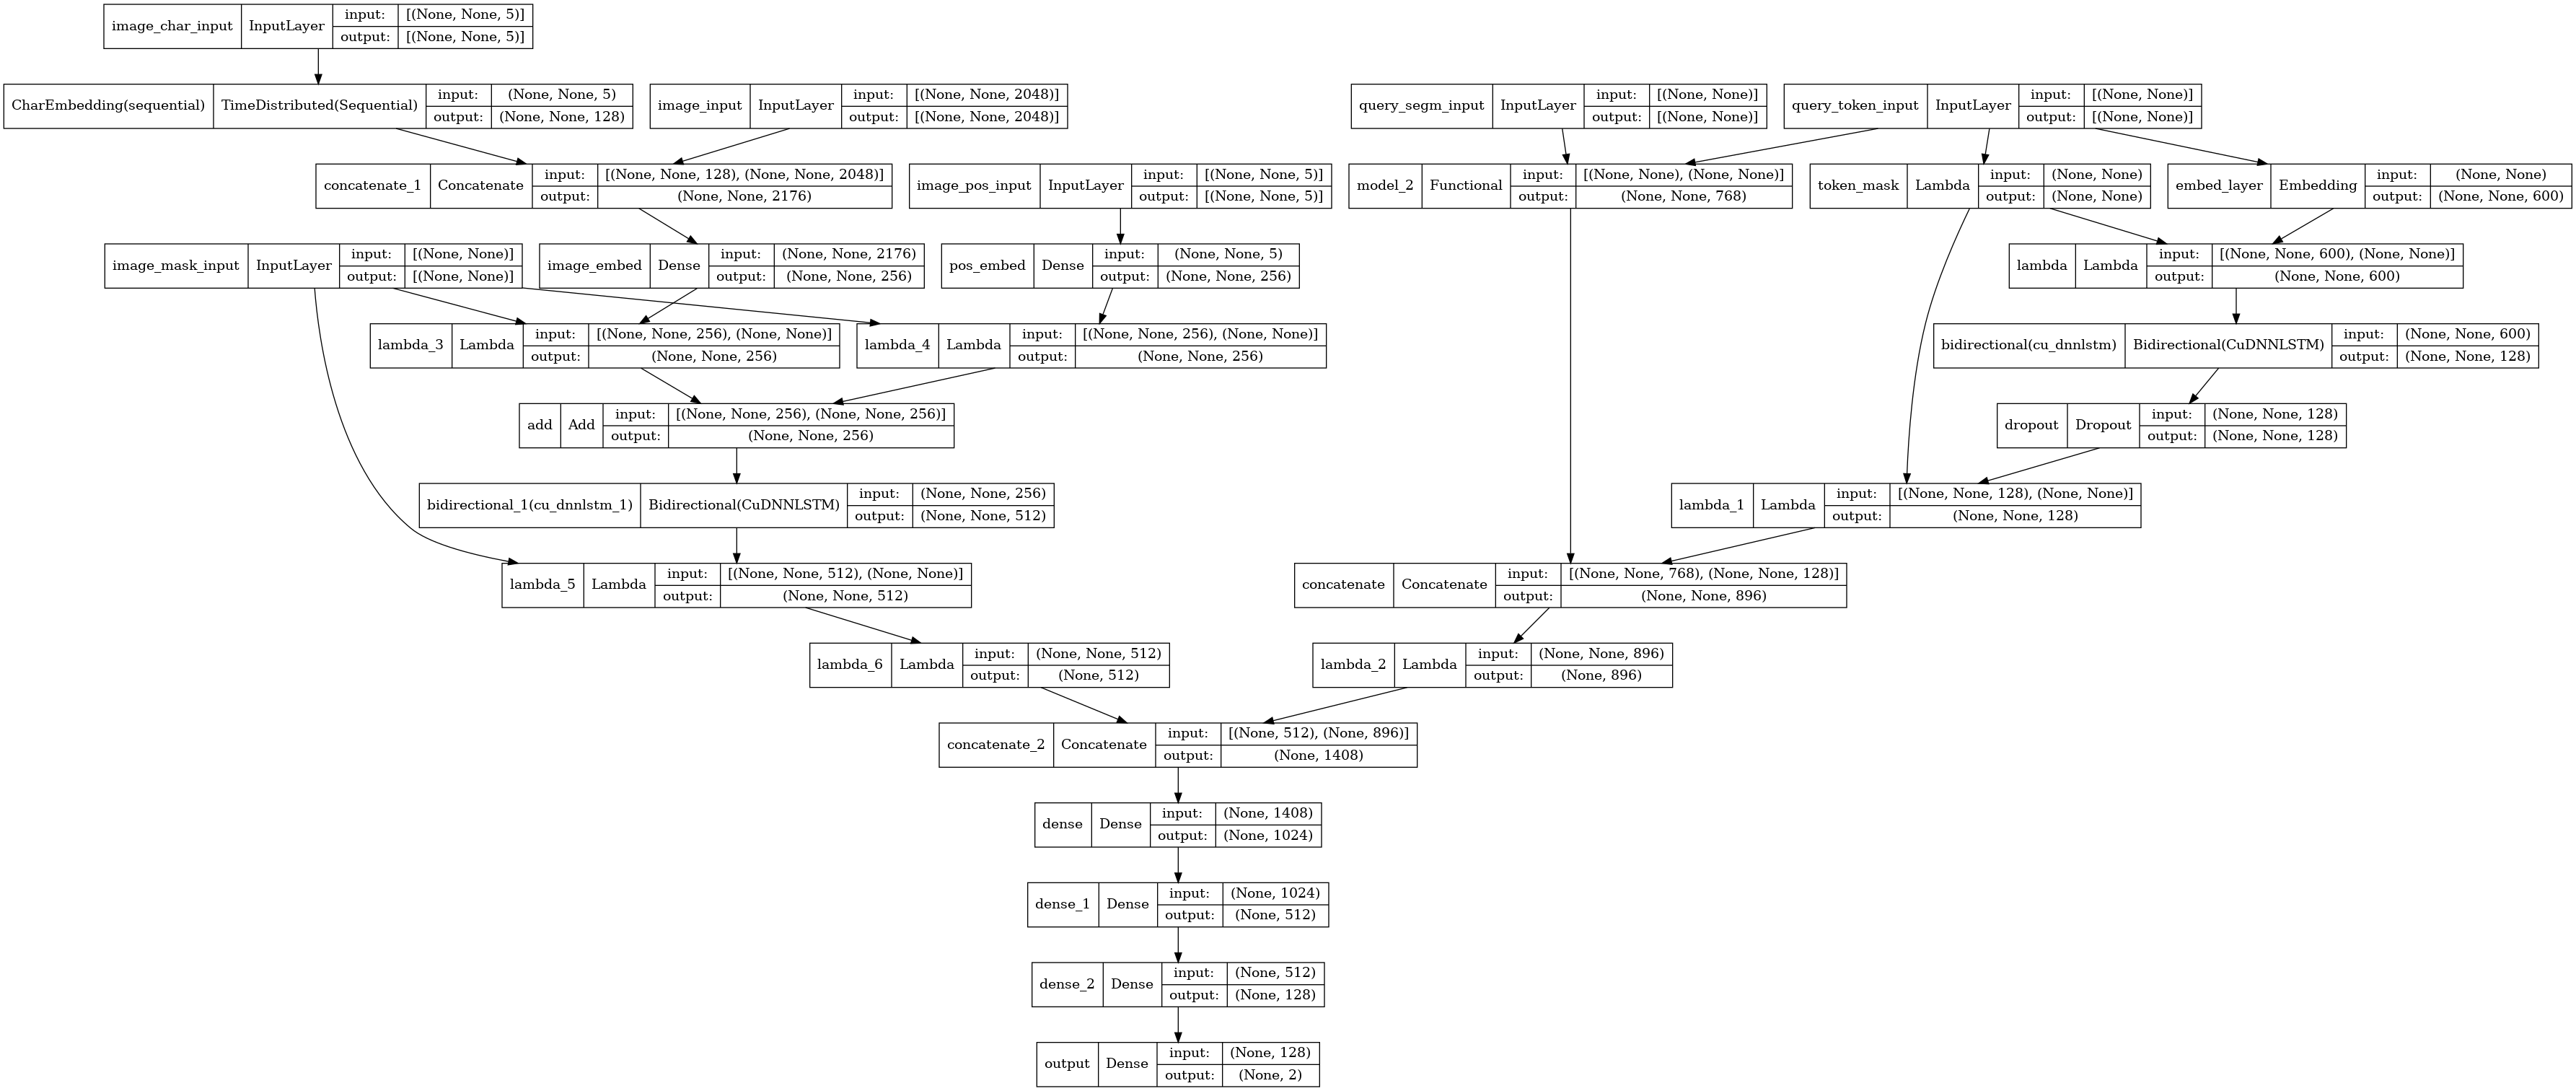

In [26]:

gc.collect()
fold_id = -1
print("\n\n[!] fold_id = {} starting".format(fold_id))
cfg["filename"] = cfg["raw_filename"].format(cfg["verbose"], FOLD_NUM, fold_id)


cfg["num_example"] = len(train_data)

tf.compat.v1.keras.backend.clear_session()
gc.collect()
seed(SEED - fold_id)
np.random.seed(SEED - fold_id)
tf.compat.v1.random.set_random_seed(SEED - fold_id)
train_D = data_generator(train_data)
print(cfg)
model = build_model(cfg, summary=True, 
                    word_embedding_matrix=word_embedding_matrix,
                    )
tf.keras.utils.plot_model(model, to_file="models/model_v1.png", show_shapes=True)
#     model.load_weights('[image-concat-query]-wwm_uncased_L24-1024_20oof0')

#     checkpoint= ModelCheckpoint(cfg["filename"], monitor='acc', verbose=1, save_best_only=False, mode='max') 


### Model Fitting

In [28]:
import datetime

# tf.compat.v1.keras.backend.clear_session()
evaluator = Evaluate(filename=cfg["filename"])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.compat.v1.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# def lr_schedule(epoch):
#   """
#   Returns a custom learning rate that decreases as epochs progress.
#   """
#   learning_rate = 0.2
#   if epoch > 10:
#     learning_rate = 0.02
#   if epoch > 20:
#     learning_rate = 0.01
#   if epoch > 50:
#     learning_rate = 0.005

#   tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
#   return learning_rate

# lr_callback = tf.compat.v1.keras.callbacks.LearningRateScheduler(lr_schedule)

model.fit(train_D.__iter__(),
                          steps_per_epoch=len(train_D),
                          epochs=MAX_EPOCH,
                          callbacks=[evaluator, tensorboard_callback],
                          shuffle=True
                          )
print("\n\n[!] fold_id = {} finish".format(fold_id))
del model, evaluator

[!] test load&save model
Epoch 1/20
157/157 [==============================] - ETA: 0s - loss: 0.5496 - accuracy: 0.4191

100%|██████████| 14720/14720 [00:00<00:00, 84307.27it/s]


[!] epoch = 1, new best score = 0.24335424443246656
[!] epoch = 1, score = 0.24335424443246656, best score: 0.24335424443246656

157/157 [==============================] - 1952s 13s/step - loss: 0.5496 - accuracy: 0.4191
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 0.5040 - accuracy: 0.3986

100%|██████████| 14720/14720 [00:00<00:00, 81794.32it/s]


[!] epoch = 2, score = 0.23501541739668336, best score: 0.24335424443246656

157/157 [==============================] - 1940s 12s/step - loss: 0.5040 - accuracy: 0.3986
Epoch 3/20
157/157 [==============================] - ETA: 0s - loss: 0.5004 - accuracy: 0.4110

100%|██████████| 14720/14720 [00:00<00:00, 85383.19it/s]


[!] epoch = 3, new best score = 0.2698517683401022
[!] epoch = 3, score = 0.2698517683401022, best score: 0.2698517683401022

157/157 [==============================] - 1944s 12s/step - loss: 0.5004 - accuracy: 0.4110
Epoch 4/20
157/157 [==============================] - ETA: 0s - loss: 0.4422 - accuracy: 0.4019

100%|██████████| 14720/14720 [00:00<00:00, 88803.07it/s]


[!] epoch = 4, score = 0.26120661575096643, best score: 0.2698517683401022

157/157 [==============================] - 1943s 12s/step - loss: 0.4422 - accuracy: 0.4019
Epoch 5/20
157/157 [==============================] - ETA: 0s - loss: 0.4387 - accuracy: 0.4184

100%|██████████| 14720/14720 [00:00<00:00, 15939.52it/s]

[!] epoch = 5, new best score = 0.2877142796178474
[!] epoch = 5, score = 0.2877142796178474, best score: 0.2877142796178474

157/157 [==============================] - 1948s 12s/step - loss: 0.4387 - accuracy: 0.4184
Epoch 6/20
157/157 [==============================] - ETA: 0s - loss: 0.4043 - accuracy: 0.4111

100%|██████████| 14720/14720 [00:00<00:00, 85330.91it/s]


[!] epoch = 6, new best score = 0.3040646701678953
[!] epoch = 6, score = 0.3040646701678953, best score: 0.3040646701678953

157/157 [==============================] - 1944s 12s/step - loss: 0.4043 - accuracy: 0.4111
Epoch 7/20
157/157 [==============================] - ETA: 0s - loss: 0.4141 - accuracy: 0.4198

100%|██████████| 14720/14720 [00:00<00:00, 87006.25it/s]


[!] epoch = 7, score = 0.2271862192671369, best score: 0.3040646701678953

157/157 [==============================] - 1941s 12s/step - loss: 0.4141 - accuracy: 0.4198
Epoch 8/20
157/157 [==============================] - ETA: 0s - loss: 0.3739 - accuracy: 0.4181

100%|██████████| 14720/14720 [00:00<00:00, 70233.89it/s]


[!] epoch = 8, score = 0.29701936236972637, best score: 0.3040646701678953

157/157 [==============================] - 1944s 12s/step - loss: 0.3739 - accuracy: 0.4181
Epoch 9/20
157/157 [==============================] - ETA: 0s - loss: 0.3825 - accuracy: 0.4278

100%|██████████| 14720/14720 [00:00<00:00, 61312.62it/s]


[!] epoch = 9, new best score = 0.30715622443769575
[!] epoch = 9, score = 0.30715622443769575, best score: 0.30715622443769575

157/157 [==============================] - 1946s 12s/step - loss: 0.3825 - accuracy: 0.4278
Epoch 10/20
157/157 [==============================] - ETA: 0s - loss: 0.3609 - accuracy: 0.4161

100%|██████████| 14720/14720 [00:00<00:00, 69080.98it/s]

[!] epoch = 10, score = 0.29624536118936395, best score: 0.30715622443769575

157/157 [==============================] - 1958s 13s/step - loss: 0.3609 - accuracy: 0.4161
Epoch 11/20
157/157 [==============================] - ETA: 0s - loss: 0.3664 - accuracy: 0.4271

100%|██████████| 14720/14720 [00:00<00:00, 83707.41it/s]


[!] epoch = 11, score = 0.2988134440994215, best score: 0.30715622443769575

157/157 [==============================] - 2259s 14s/step - loss: 0.3664 - accuracy: 0.4271
Epoch 12/20
157/157 [==============================] - ETA: 0s - loss: 0.3352 - accuracy: 0.4254

100%|██████████| 14720/14720 [00:00<00:00, 91795.05it/s]


[!] epoch = 12, new best score = 0.33423550245061007
[!] epoch = 12, score = 0.33423550245061007, best score: 0.33423550245061007

157/157 [==============================] - 1944s 12s/step - loss: 0.3352 - accuracy: 0.4254
Epoch 13/20
157/157 [==============================] - ETA: 0s - loss: 0.3479 - accuracy: 0.4276

100%|██████████| 14720/14720 [00:00<00:00, 81732.82it/s]


[!] epoch = 13, score = 0.30275629873107657, best score: 0.33423550245061007

157/157 [==============================] - 1943s 12s/step - loss: 0.3479 - accuracy: 0.4276
Epoch 14/20
157/157 [==============================] - ETA: 0s - loss: 0.3221 - accuracy: 0.4290

100%|██████████| 14720/14720 [00:00<00:00, 90972.81it/s]


[!] epoch = 14, score = 0.2863367206204389, best score: 0.33423550245061007

157/157 [==============================] - 1941s 12s/step - loss: 0.3221 - accuracy: 0.4290
Epoch 15/20
157/157 [==============================] - ETA: 0s - loss: 0.3338 - accuracy: 0.4261

100%|██████████| 14720/14720 [00:00<00:00, 113375.39it/s]


[!] epoch = 15, score = 0.32555840940542996, best score: 0.33423550245061007

157/157 [==============================] - 1943s 12s/step - loss: 0.3338 - accuracy: 0.4261
Epoch 16/20
157/157 [==============================] - ETA: 0s - loss: 0.3121 - accuracy: 0.4298

100%|██████████| 14720/14720 [00:00<00:00, 93604.26it/s]


[!] epoch = 16, new best score = 0.3357918707417937
[!] epoch = 16, score = 0.3357918707417937, best score: 0.3357918707417937

157/157 [==============================] - 1939s 12s/step - loss: 0.3121 - accuracy: 0.4298
Epoch 17/20
157/157 [==============================] - ETA: 0s - loss: 0.3358 - accuracy: 0.4224

100%|██████████| 14720/14720 [00:00<00:00, 82823.22it/s]


[!] epoch = 17, score = 0.3045791262443236, best score: 0.3357918707417937

157/157 [==============================] - 1944s 12s/step - loss: 0.3358 - accuracy: 0.4224
Epoch 18/20
157/157 [==============================] - ETA: 0s - loss: 0.3096 - accuracy: 0.4337

100%|██████████| 14720/14720 [00:00<00:00, 91193.05it/s]


[!] epoch = 18, score = 0.33459664113649484, best score: 0.3357918707417937

157/157 [==============================] - 1942s 12s/step - loss: 0.3096 - accuracy: 0.4337
Epoch 19/20
157/157 [==============================] - ETA: 0s - loss: 0.3304 - accuracy: 0.4231

100%|██████████| 14720/14720 [00:00<00:00, 80900.88it/s]


[!] epoch = 19, score = 0.32829942947141055, best score: 0.3357918707417937

157/157 [==============================] - 1939s 12s/step - loss: 0.3304 - accuracy: 0.4231
Epoch 20/20
157/157 [==============================] - ETA: 0s - loss: 0.3334 - accuracy: 0.4296

100%|██████████| 14720/14720 [00:00<00:00, 65584.38it/s]


[!] epoch = 20, score = 0.3330643792697904, best score: 0.3357918707417937

157/157 [==============================] - 1946s 12s/step - loss: 0.3334 - accuracy: 0.4296


[!] fold_id = -1 finish


In [ ]:
%tensorboard --logdir logs/fit

# Predict

In [29]:
with open('data/testA_data.pkl', 'rb') as outp:
    test_data = pickle.load(outp)

f = cfg["filename"] + ".h5"
if "bert" in cfg["verbose"]:
    custom_objects = get_custom_objects()
    model = load_model(f, custom_objects=custom_objects)  
else:
    model = load_model(f)
print("finish")

finish


In [30]:
gc.collect()
result = defaultdict(list)
for i in trange(len(test_data)):
    d = test_data.iloc[i]
    qid = d['query_id']
    pid = d['product_id']
    text = d['query']
    label_words = d['label_words']
    t1, t2 = token2id_X(text, x_dict=word_index, maxlen=cfg["maxlen"])

    image = np.array(d['feature_convert'], dtype="float32")
    image = image[: cfg["max_box"]]
    img_mask = [1 for _ in image[: cfg["max_box"]]]                   
    pos = np.array(d['pos'], dtype="float32")
    pos = pos[: cfg["max_box"]]

    image_char = [token2id_X(ent, x_dict=word_index)[0] for ent in label_words.split(IMAGE_LABEM_CONCAT_TOKEN)]
    image_char = image_char[: cfg["max_box"]]
    image_char = pad_sequences(image_char, 
                               maxlen=cfg["max_char"], 
                               dtype='int32',
                               padding='post',
                               truncating='post',
                               value=cfg["x_pad"]) 
    output = model.predict([np.asarray([t1]), np.asarray([t2]), np.asarray([image]), np.asarray([img_mask]), np.asarray([pos]), np.asarray([image_char])])
    result[qid].append((pid, output[0][1]))


100%|██████████| 28830/28830 [1:00:59<00:00,  7.88it/s]


In [31]:
query_id,product1,product2,product3,product4,product5 = [],[],[],[],[],[]
for key in result.keys():
    rlist = result[key]
    rlist.sort(key=lambda x: x[1], reverse=True)
    query_id.append(key)
    product1.append(rlist[0][0])
    product2.append(rlist[1][0])
    product3.append(rlist[2][0])
    product4.append(rlist[3][0])
    product5.append(rlist[4][0])

sub = pd.DataFrame({'query-id':query_id,
                    'product1':product1,
                    'product2':product2,
                    'product3':product3,
                    'product4':product4,
                    'product5':product5,

})

sub.to_csv('result/submission.csv',index=0)

In [32]:
sub.head(5)

,query-id,product1,product2,product3,product4,product5
0,0,103066188,103043601,103036197,103044507,103038604
1,1,103041536,103018092,103029531,103064594,103031606
2,2,103034398,103047101,103018864,103054005,103050264
3,3,103032254,103020362,103007742,103064876,103040094
4,4,103057584,103040494,103054847,103039937,103039122


## Eval

In [33]:
!python eval.py data/testA_answer.json result/submission.csv result/test_result.json

Read standard from data/testA_answer.json
Read user submit file from result/submission.csv
The evaluation failed: 2
